**Index Construction Methodology Explained**

The process of constructing the index in the provided code revolves around aggregating item-specific data (price and quantity), and applying 'caps' to this aggregated data. Here's a breakdown of the steps involved:

1. **Item-specific Index Calculation:** 
   For each item, identified by `market_hash_name`, an 'index' value is computed. This index for an item is derived as the product of its price and quantity:
   index = price * quantity

2. **Computing Index Share:** 
   To understand the relative importance or weight of an item's index in the entire dataset, an 'index share' for each item is calculated. It is the ratio of an item's index to the sum of indices for all items.
   index_share = item's index / sum of all indices

3. **Applying Caps to Index Share:** 
   Every item has an upper and a lower limit defined for its index share. These are termed as 'caps'. If an item's index share falls outside of these caps, it is considered to be invalid for direct summing in the next step.

4. **Summing the Valid Indices:** 
   All the items whose index share falls within their specified caps are considered 'valid'. The index values for all such valid items are summed together.

5. **Adjusting for Invalid Items:** 
   Items that don't fall within their index share caps are considered 'invalid'. For these items, instead of their actual index values, their respective upper or lower cap values are summed. For instance:
   - If an item's index share is less than its lower cap, the lower cap is considered.
   - If an item's index share is more than its upper cap, the upper cap is considered.

6. **Deriving the Total Index Value:** 
   The final index value, representing the whole data pull, is obtained by dividing the summed index of valid items by (1 minus the summed caps of invalid items):
   Total index = Sum of valid indices / (1 - Sum of invalid caps)

This methodology ensures that while every item influences the final index value, those items that have disproportionately large or small index shares, as defined by their caps, don't unduly skew the overall index. Instead, their influence is confined within predefined limits, ensuring that the final index is representative and robust.

**Example:**

**Setup:**

Suppose we have 4 items (skins) in the market:

| market_hash_name | price (USD) | quantity | index | index_share |
|------------------|-------------|----------|-------|-------------|
| Skin A           | 10          | 5        | 50    | ?           |
| Skin B           | 20          | 2        | 40    | ?           |
| Skin C           | 5           | 10       | 50    | ?           |
| Skin D           | 15          | 1        | 15    | ?           |
| **Total**            |             |          | **155**   | 1           |

Firstly, let's calculate the `index_share` for each item:

Total index = 50 (A) + 40 (B) + 50 (C) + 15 (D) = 155

- Skin A's index_share = 50/155 ≈ 0.32
- Skin B's index_share = 40/155 ≈ 0.26
- Skin C's index_share = 50/155 ≈ 0.32
- Skin D's index_share = 15/155 ≈ 0.10

**Caps:**

Now, assume we've predetermined caps (upper and lower) for each skin:

| market_hash_name | lower_cap_index_share | upper_cap_index_share |
|------------------|-----------------------|-----------------------|
| Skin A           | 0.20                  | 0.35                  |
| Skin B           | 0.10                  | 0.30                  |
| Skin C           | 0.25                  | 0.40                  |
| Skin D           | 0.05                  | 0.15                  |

**Checking Against Caps:**

1. **Skin A**: 0.32 is between 0.20 and 0.35 → **Valid**
2. **Skin B**: 0.26 is between 0.10 and 0.30 → **Valid**
3. **Skin C**: 0.32 is between 0.25 and 0.40 → **Valid**
4. **Skin D**: 0.10 is between 0.05 and 0.15 → **Valid**

All skins are within their respective caps, so there are no invalid entries. The summed index of all valid skins is 155.

Now, for the sake of the example, let’s imagine if Skin A had an index_share of 0.37 (outside its cap). In such a case:

- Invalid upper cap of Skin A = 0.35 (as 0.37 > 0.35)
- Valid summed index (without Skin A) = 105
- Total invalid cap = 0.35 (only Skin A is invalid)

Finally:
Total index = 105 / (1 - 0.35) = 161.54

The adjusted index incorporates the influence of Skin A but ensures its effect is limited to the predefined cap, providing a balanced representation of the overall market.

In [418]:
import numpy as np
import gc
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from getpass import getpass
import warnings
warnings.filterwarnings('ignore')

# Data pre-prep; Don't run again

In [419]:
df1 = pd.read_csv('data/csgo_price_hist.csv')
df2 = pd.read_csv('data/csgo_price_hist2.csv')

In [421]:
duplicate_check = df1.merge(df2, on=list(df1.columns), how="inner")
if duplicate_check.shape[0] == 0:
  print('No duplicates across df1 and df2')

In [ ]:
def agg_hist_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group the dataframe by 'market', 'market_hash_name', and 'dates.date'.
    Sums the 'quantity' and takes the minimum of 'price'.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The aggregated DataFrame.
    """
    return df.groupby(['market_hash_name', 'dates.date']).agg({
        'quantity': 'sum',
        'price': 'min'
    }).reset_index()


agg_df1 = agg_hist_data(df1)
agg_df2 = agg_hist_data(df2)

print(agg_df1.shape)
print(agg_df2.shape)

(192366, 4)
(7132894, 4)


In [ ]:
del df1
del df2
gc.collect()

In [ ]:
agg_df_hist = pd.concat([agg_df1, agg_df2])
agg_df_hist.to_csv('data/csgo_agg_df_hist.csv')
agg_df_hist.shape

(7325260, 4)

In [ ]:
agg_df_hist.sort_values('dates.date', ascending=False).head()

,market_hash_name,dates.date,quantity,price
7132893,★ Ursus Knife | Urban Masked (Well-Worn),2023-09-19,50,12593
1343707,Pinups Capsule,2023-09-19,2359,81
2747607,StatTrak™ AK-47 | Rat Rod (Battle-Scarred),2023-09-19,247,762
5936742,USP-S | Guardian (Minimal Wear),2023-09-19,1833,339
1344071,Poorly Drawn Capsule,2023-09-19,722,80


In [ ]:
agg_df_hist = pd.read_csv('data/csgo_agg_df_hist.csv', index_col=0)
agg_df_hist.price = agg_df_hist.price/100  # Get data in USD (isntead of USD cents)
agg_df_hist = agg_df_hist.loc[(agg_df_hist['dates.date'] > '2022-09-20') & 
                              (agg_df_hist['dates.date'] < '2023-09-19'), :]

In [ ]:
fluctuation = agg_df_hist.groupby('market_hash_name').agg({
    'quantity': ['std', 'mean', 'min', 'max',
                 lambda x: x.quantile(0.10),
                 lambda x: x.quantile(0.25),
                 lambda x: x.quantile(0.50),
                 lambda x: x.quantile(0.75),
                 lambda x: x.quantile(0.90)],
    'price': ['mean']
}).reset_index()

fluctuation.columns = [
    'market_hash_name',
    'std_quantity',
    'mean_quantity',
    'min_quantity',
    'max_quantity',
    '10th_percentile_quantity',
    '25th_percentile_quantity',
    'median',
    '75th_percentile_quantity',
    '90th_percentile_quantity',
    'mean_price'
]

fluctuation['coef_of_variation'] = fluctuation['std_quantity'] / fluctuation['mean_quantity']
fluctuation.head()


,market_hash_name,std_quantity,mean_quantity,min_quantity,max_quantity,10th_percentile_quantity,25th_percentile_quantity,median,75th_percentile_quantity,90th_percentile_quantity,mean_price,coef_of_variation
0,'Medium Rare' Crasswater | Guerrilla Warfare,306.448272,1000.168044,236,1589,674.0,771.0,908.0,1313.5,1428.8,8.491983,0.306397
1,'The Doctor' Romanov | Sabre,301.795136,3281.994490,2025,3901,2889.8,3077.0,3268.0,3503.5,3711.0,3.829394,0.091955
2,'Two Times' McCoy | TACP Cavalry,448.358181,1454.044077,711,2445,904.0,1095.5,1340.0,1831.5,2111.8,1.686722,0.308353
3,'Two Times' McCoy | USAF TACP,574.310914,1993.162534,698,3231,1267.4,1546.5,1866.0,2465.0,2799.0,1.639339,0.288141
4,10 Year Birthday Sticker Capsule,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265


In [ ]:
agg_df_hist = agg_df_hist.merge(fluctuation, on='market_hash_name', how='inner')
agg_df_hist.to_csv('data/csgo_agg_df_hist_fluct.csv')

# Start here

In [ ]:
agg_df_hist = pd.read_csv('data/csgo_agg_df_hist_fluct.csv', index_col=0)
print('shape: ', agg_df_hist.shape)
agg_df_hist.head()

shape:  (7304522, 15)


,market_hash_name,dates.date,quantity,price,std_quantity,mean_quantity,min_quantity,max_quantity,10th_percentile_quantity,25th_percentile_quantity,median,75th_percentile_quantity,90th_percentile_quantity,mean_price,coef_of_variation
0,10 Year Birthday Sticker Capsule,2022-09-21,3620,0.74,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265
1,10 Year Birthday Sticker Capsule,2022-09-22,3465,0.73,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265
2,10 Year Birthday Sticker Capsule,2022-09-23,3364,0.73,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265
3,10 Year Birthday Sticker Capsule,2022-09-24,2906,0.73,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265
4,10 Year Birthday Sticker Capsule,2022-09-25,2460,0.74,2651.694205,5343.300275,1260,12531,2089.4,3294.0,4782.0,7224.5,9408.6,0.768457,0.496265


# Useful functions

In [ ]:
def construct_index(df):
    # Convert the 'dates.date' column to datetime
    df['dates.date'] = pd.to_datetime(df['dates.date'])

    # Calculate the index for each day
    df['index'] = df['quantity'] * df['price']

    # Group by date and sum the indices
    index_data = df.groupby('dates.date')['index'].sum().reset_index()

    return index_data


In [ ]:
def plot_indexes(index1, index2, title):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=index1['dates.date'], y=index1['index'], name='Index 1', mode='lines'))

    fig.add_trace(go.Scatter(x=index2['dates.date'], y=index2['index'], name='Index 2', mode='lines'))

    fig.update_layout(
        title=title,
        xaxis_title='dates',
        yaxis_title='index'
    )

    fig.show()

In [ ]:
raw_index = construct_index(agg_df_hist)

fig = px.line(raw_index, x='dates.date', y='index', title='Raw CS:GO Skin Index')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Index Value')
fig.show()

In [ ]:
def most_traded_index(df, n, quantity_measure, raw_index=raw_index,
                      compare=True, min_quantity=0, plot=True):

  # Supported quantity_measure values:
  # "mean_quantity", "min_quantity", "max_quantity", "10th_percentile_quantity",
  # "25th_percentile_quantity", "median",	"75th_percentile_quantity",
  # "90th_percentile_quantity"

  # Calculate number of unique price points for each market_hash_name
  unique_prices = df.groupby('market_hash_name')['price'].nunique().reset_index()
  unique_prices = unique_prices.rename(columns={'price': 'unique_prices'})

  df = df.merge(unique_prices, on='market_hash_name', how='left')
  
  traded_ranking = df[['market_hash_name', 'unique_prices']]\
        .drop_duplicates()\
        .sort_values('unique_prices', ascending=False)
  
  most_traded = df[['market_hash_name', 'dates.date', 'price', quantity_measure]]
  most_traded = most_traded.rename(columns={quantity_measure: 'quantity'})
  top_n_mt = list(traded_ranking[:n]['market_hash_name'])
  most_traded = most_traded[most_traded['market_hash_name'].isin(top_n_mt)]
  most_traded = most_traded[most_traded.quantity >= min_quantity]
  mt_n_index = construct_index(most_traded)
  if plot:
    if compare:
      plot_indexes(raw_index, mt_n_index, f'Most traded {n} (min quantity {min_quantity}) vs raw')
    else:
      fig = px.line(mt_n_index, x='dates.date', y='index', title=f'Most traded {n} (min quantity {min_quantity})')
      fig.update_xaxes(title_text='Date')
      fig.update_yaxes(title_text='Index Value')
      fig.show()
  print(f'Number of products: {most_traded.market_hash_name.drop_duplicates().count()}')
  return mt_n_index, most_traded

In [ ]:
def simulate_attack(df, item_list, day_count, increase=True):
  # Start from the 20th date in the data. It could be anything.
  date_list = [df['dates.date'][20] + pd.Timedelta(days=i) for i in range(day_count)]
  # Days and items to target
  condition = ((df['market_hash_name'].isin(item_list)) & (df['dates.date'].isin(date_list)))
  if increase:
    # Attack makes the index of each item equal to 1 trillion
    df['index'] = np.where(condition, 1e12, df['index'])
  else:
    # Attack makes the index value of the input items 0
    df['index'] = np.where(condition, 0, df['index'])
  return df

In [ ]:
def get_avg_share(df):
    # GET INDEX SHARE
    daily_sum = df.groupby('dates.date')['index'].sum().reset_index()
    daily_sum = daily_sum.rename(columns={'index': 'daily_sum_index'})
    df = df.merge(daily_sum, on='dates.date')
    df['index_share'] = (df['index'] / df['daily_sum_index'])
    df = df.drop(columns=['daily_sum_index'])

    # GET MAPPING
    half_year_date = df.loc[:, "dates.date"].drop_duplicates().iloc[182,]
    avg_mapping = df.loc[df['dates.date'] < half_year_date, ['market_hash_name', 'dates.date', 'index_share']]

    # Compute mean and standard deviation of index_share by market_hash_name
    avg_mapping = avg_mapping.groupby('market_hash_name')['index_share'].agg(['mean', 'std']).reset_index()
    avg_mapping = avg_mapping.rename(columns={'mean': 'avg_index_share', 'std': 'std_index_share'})

    df = df[df['dates.date'] > half_year_date]
    df = df.merge(avg_mapping, on='market_hash_name', how='inner')
    return df, avg_mapping

In [ ]:
def get_index_share(df):
    # GET INDEX SHARE
    daily_sum = df.groupby('dates.date')['index'].sum().reset_index()
    daily_sum = daily_sum.rename(columns={'index': 'daily_sum_index'})
    df = df.merge(daily_sum, on='dates.date')
    df['index_share'] = (df['index'] / df['daily_sum_index'])
    df = df.drop(columns=['daily_sum_index'])
    return df

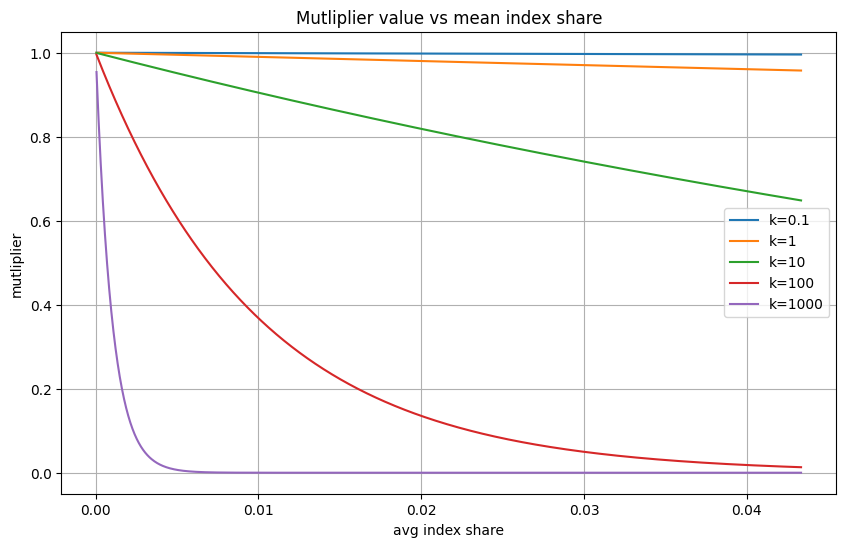

In [551]:
# def get_caps(mapping):
#   mapping['cap_index_share'] = np.where(mapping['avg_index_share'] < 0.005, 0.01,
#                                             np.where(mapping['avg_index_share'] < 0.01, 0.015,
#                                                     np.where(mapping['avg_index_share'] < 0.02, 0.025,
#                                                               np.where(mapping['avg_index_share'] < 0.03, 0.032,
#                                                                       np.where(mapping['avg_index_share'] < 0.04, 0.041,
#                                                                                 np.where(mapping['avg_index_share'] < 0.05, 0.05, mapping['avg_index_share']
#                                                                                         )
#                                                                                 )
#                                                                       )
#                                                               )
#                                                     )
#                                             )
#   return mapping

def compute_multiplier(mean, k):
    return np.exp(-k * mean)


k_values = [0.1, 1, 10, 100, 1000]
mean_values = np.linspace(mapping['avg_index_share'].min(), mapping['avg_index_share'].max(), 1000)
multiplier_values = {k: compute_multiplier(mean_values, k) for k in k_values}
plt.figure(figsize=(10, 6))
for k, multiplier in multiplier_values.items():
    plt.plot(mean_values, multiplier, label=f'k={k}')
    
plt.xlabel('avg index share')
plt.ylabel('mutliplier')
plt.title('Mutliplier value vs mean index share')
plt.legend()
plt.grid(True)
plt.show()


def get_caps(mapping, upper_multiplier=1, lower_multiplier=1, items=None):
  '''
  Get caps for the index share of each item in the mapping.
  If `items` is not None, then the caps are only applied to the items in the list.
  Else, the caps are applied to all items.
  '''

  if not items:
    mapping['upper_cap_index_share'] = mapping['avg_index_share'] + upper_multiplier*mapping['std_index_share']
    mapping['lower_cap_index_share'] = np.where(mapping['avg_index_share'] - lower_multiplier*mapping['std_index_share'] > 0,
                                              mapping['avg_index_share'] - lower_multiplier*mapping['std_index_share'], 0)
  if items:
    # Apply caps only to the items in the list
    mapping['upper_cap_index_share'] = np.where(
      mapping['market_hash_name'].isin(items),
      mapping['avg_index_share'] + upper_multiplier*mapping['std_index_share'],
      1
    )
    mapping['lower_cap_index_share'] = np.where(
      mapping['market_hash_name'].isin(items),
      np.where(mapping['avg_index_share'] - lower_multiplier*mapping['std_index_share'] > 0,
                mapping['avg_index_share'] - lower_multiplier*mapping['std_index_share'], 0),
      0
    )
  return mapping


def get_caps_k(mapping, k=100):
  '''
  Get caps for the index share of each item in the mapping.
  If `items` is not None, then the caps are only applied to the items in the list.
  Else, the caps are applied to all items.
  '''
  mapping['upper_cap_index_share'] = mapping['avg_index_share'] + np.exp(-k*mapping['avg_index_share'])*mapping['std_index_share']
  mapping['lower_cap_index_share'] = np.where(mapping['avg_index_share'] - np.exp(-k*mapping['avg_index_share'])*mapping['std_index_share'] > 0,
                                            mapping['avg_index_share'] - np.exp(-k*mapping['avg_index_share'])*mapping['std_index_share'], 0)
  return mapping

In [578]:
# def cap_index(df):
#   valid = df[(df['index_share'] >= df['lower_cap_index_share']) & 
#              (df['index_share'] <= df['upper_cap_index_share'])]
#   valid_ind = pd.DataFrame(valid.groupby('dates.date')['index'].sum()).reset_index().rename(columns={'index': 'sum_index'})
  
#   # Invalid Entries: Those below lower_cap_index_share
#   invalid_lower = df[df['index_share'] < df['lower_cap_index_share']]
#   invalid_lower_ind = pd.DataFrame(invalid_lower.groupby('dates.date')['lower_cap_index_share'].sum()).reset_index().rename(columns={'lower_cap_index_share': 'sum_lower_cap_index_share'})

#   # Invalid Entries: Those above upper_cap_index_share
#   invalid_upper = df[df['index_share'] > df['upper_cap_index_share']]
#   invalid_upper_ind = pd.DataFrame(invalid_upper.groupby('dates.date')['upper_cap_index_share'].sum()).reset_index().rename(columns={'upper_cap_index_share': 'sum_upper_cap_index_share'})

#   # Merging
#   all_ind = valid_ind.merge(invalid_lower_ind, on=['dates.date'], how='left').merge(invalid_upper_ind, on=['dates.date'], how='left')
#   all_ind = all_ind.fillna({'sum_lower_cap_index_share': 0, 'sum_upper_cap_index_share': 0})

#   # Calculating the adjusted index 
#   all_ind['index'] = all_ind['sum_index'] / (1 - all_ind['sum_lower_cap_index_share'] - all_ind['sum_upper_cap_index_share'])

#   return all_ind, valid, invalid_lower, invalid_upper


# def cap_index(df):
#     all_dates = pd.DataFrame(df['dates.date'].drop_duplicates())

#     valid = df[(df['index_share'] >= df['lower_cap_index_share']) & 
#                 (df['index_share'] <= df['upper_cap_index_share'])]
#     valid_ind = pd.DataFrame(valid.groupby('dates.date')['index'].sum()).reset_index().rename(columns={'index': 'sum_index'})

#     # Invalid Entries: Those below lower_cap_index_share
#     invalid_lower = df[df['index_share'] < df['lower_cap_index_share']]
#     invalid_lower_ind = pd.DataFrame(invalid_lower.groupby('dates.date')['lower_cap_index_share'].sum()).reset_index().rename(columns={'lower_cap_index_share': 'sum_lower_cap_index_share'})

#     # Invalid Entries: Those above upper_cap_index_share
#     invalid_upper = df[df['index_share'] > df['upper_cap_index_share']]
#     invalid_upper_ind = pd.DataFrame(invalid_upper.groupby('dates.date')['upper_cap_index_share'].sum()).reset_index().rename(columns={'upper_cap_index_share': 'sum_upper_cap_index_share'})

#     # Merging
#     all_ind = valid_ind.merge(invalid_lower_ind, on=['dates.date'], how='left').merge(invalid_upper_ind, on=['dates.date'], how='left')
#     all_ind = all_ind.fillna({'sum_lower_cap_index_share': 0, 'sum_upper_cap_index_share': 0})

#     # Calculating the adjusted index 
#     all_ind['index'] = all_ind['sum_index'] / (1 - all_ind['sum_lower_cap_index_share'] - all_ind['sum_upper_cap_index_share'])



#     # ------------------------------


#     # It might happen that some days have no valid entries, or very few valid entries.
#     # Example, when index for one item is manipulated to nearly 100%, then naturally,
#     # all other items go to 0%. In this case, the manipulated item is above its cap
#     # and all other items are below their caps. So, none are valid.
#     few_items_dates = all_dates.merge(valid, on='dates.date', how='left').fillna(0)
#     # Count distinct market_hash_names on each date
#     few_items_dates = few_items_dates.groupby('dates.date')['market_hash_name'].nunique().reset_index()
#     few_items_dates = few_items_dates.rename(columns={'market_hash_name': 'num_items'})
#     # limit to num_items < n
#     few_items_dates = few_items_dates[few_items_dates['num_items'] < 50]
#     few_items_dates_list = few_items_dates['dates.date'].tolist()

#     if len(few_items_dates_list) == 0:
#         return all_ind, valid, invalid_lower, invalid_upper

#     lookback_window = 10
#     needed_dates = []
#     for date in few_items_dates_list:
#         start_date = date - pd.Timedelta(days=lookback_window+1)
#         needed_dates.extend(pd.date_range(start_date, date))
#     needed_dates_set = set(needed_dates)

#     for dt in few_items_dates_list:
#         # Filter the dataframe to only include rows with the relevant dates
#         filtered_df = df[df['dates.date'].isin(needed_dates_set)].copy()

#         # Set the date column as the index
#         filtered_df.set_index(['market_hash_name', 'dates.date'], inplace=True)

#         # Shift the series by one day for each group
#         filtered_df['shifted_index'] = filtered_df.groupby('market_hash_name')['index'].shift(1)

#         # Use groupby with rolling on the shifted series
#         filtered_df['rolling_std'] = (filtered_df.groupby('market_hash_name')['shifted_index']
#                                     .rolling(window=10)
#                                     .std()
#                                     .reset_index(level=0, drop=True))

#         # Drop the temporary shifted column
#         # filtered_df.drop('shifted_index', axis=1, inplace=True)

#         # Reset the date column as a regular column
#         filtered_df.reset_index(inplace=True)

#         filtered_df = filtered_df[filtered_df['dates.date'].isin(few_items_dates_list)]

#         mult = 5
#         valid = filtered_df[(filtered_df['index'] < filtered_df['shifted_index'] + mult*filtered_df['rolling_std']) &
#                             (filtered_df['index'] > filtered_df['shifted_index'] - mult*filtered_df['rolling_std'])]
#         valid_ind = valid.groupby('dates.date')['index'].sum().reset_index().rename(columns={'index': 'sum_index'})

#         invalid_upper = filtered_df[(filtered_df['index'] > filtered_df['shifted_index'] + mult*filtered_df['rolling_std'])]
#         invalid_upper_ind = invalid_upper.groupby('dates.date')['upper_cap_index_share'].sum().reset_index().rename(columns={'upper_cap_index_share': 'sum_upper_cap_index_share'})

#         invalid_lower = filtered_df[(filtered_df['index'] < filtered_df['shifted_index'] - mult*filtered_df['rolling_std'])]
#         invalid_lower_ind = invalid_lower.groupby('dates.date')['lower_cap_index_share'].sum().reset_index().rename(columns={'lower_cap_index_share': 'sum_lower_cap_index_share'})

#         # Merge valid_ind, invalid_upper_ind, invalid_lower_ind
#         all_ind2 = valid_ind.merge(invalid_upper_ind, on=['dates.date'], how='left').merge(invalid_lower_ind, on=['dates.date'], how='left')
#         # Fill NaNs with 0
#         all_ind2 = all_ind2.fillna({'sum_upper_cap_index_share': 0, 'sum_lower_cap_index_share': 0})
#         all_ind2['index'] = all_ind2['sum_index'] / (1 - all_ind2['sum_lower_cap_index_share'] - all_ind2['sum_upper_cap_index_share'])
#         all_ind2['extra'] = all_ind2['index'] - valid_ind['sum_index']

#         inv_upper_caps = invalid_upper.loc[invalid_upper['dates.date'] == dt, ['market_hash_name', 'upper_cap_index_share']].rename(columns={'upper_cap_index_share': 'index_share'})
#         inv_lower_caps = invalid_lower.loc[invalid_lower['dates.date'] == dt, ['market_hash_name', 'lower_cap_index_share']].rename(columns={'lower_cap_index_share': 'index_share'})
#         inv_caps = pd.concat([inv_upper_caps, inv_lower_caps])
#         inv_caps['share_of_extra'] = inv_caps['index_share']/inv_caps['index_share'].sum()
#         extra = float(all_ind2.loc[all_ind2['dates.date'] == dt, 'extra'])
#         inv_caps['index'] = inv_caps['share_of_extra'] * extra

#         for mhn in inv_caps['market_hash_name'].unique():
#             df.loc[(df['dates.date'] == dt) & (df['market_hash_name'] == mhn), 'index'] = inv_caps.loc[inv_caps['market_hash_name'] == mhn, 'index'].values[0]

#     all_ind2.rename(columns={'index': 'index2'}, inplace=True)

#     # Merge all_ind and all_ind2, use index2 if not null, else use index
#     all_ind = all_ind.merge(all_ind2, on='dates.date', how='outer')
#     all_ind['index'] = np.where(all_ind['index2'].isnull(), all_ind['index'], all_ind['index2'])
#     all_ind.sort_values('dates.date', inplace=True)

#     return all_ind, valid, invalid_lower, invalid_upper

def cap_index(df, max_iter=1000):
    adj_list = []
    for dt in df['dates.date'].unique():
        df_sub = df.loc[df['dates.date'] == dt, ['index', 'lower_cap_index_share', 'upper_cap_index_share']]
        df_sub = adjust_elements(df_sub, max_iter=max_iter)
        df_sub['dates.date'] = dt
        adj_list.append(df_sub)
    adj_df = pd.concat(adj_list)
    adj_df = adj_df.groupby('dates.date')['index'].sum().reset_index()
    return adj_df


def adjust_elements(df, max_iter):
    # Initialize
    df['mean_cap_index_share'] = (df['lower_cap_index_share'] + df['upper_cap_index_share']) / 2
    elements = df.iloc[:, 0].tolist()
    min_percentages = df.loc[:, 'lower_cap_index_share'].tolist()
    max_percentages = df.loc[:, 'upper_cap_index_share'].tolist()
    mean_percentages = df.loc[:, 'mean_cap_index_share'].tolist()
    max_iterations = max_iter  # setting a limit to prevent infinite loops
    iterations = 0

    while iterations < max_iterations:
        # Calculate total sum
        sum_elements = sum(elements)
        
        # Calculate deviations
        deviations = []
        for i, num in enumerate(elements):
            current_percentage = num / sum_elements
            if current_percentage < min_percentages[i]:
                deviation = current_percentage - mean_percentages[i]
            elif current_percentage > max_percentages[i]:
                deviation = current_percentage - mean_percentages[i]
            else:
                deviation = 0
            deviations.append(deviation)

        # Check if all deviations are zero (all elements within their acceptable ranges)
        if all(d == 0 for d in deviations):
            break

        # Sort by deviation
        sorted_indices = sorted(range(len(deviations)), key=lambda k: abs(deviations[k]), reverse=True)

        # Adjust the Most Deviating Element
        most_deviating_index = sorted_indices[0]
        if deviations[most_deviating_index] < 0:
            # Below the acceptable range
            target_value = min_percentages[most_deviating_index] * sum_elements
        else:
            # Above the acceptable range
            target_value = max_percentages[most_deviating_index] * sum_elements

        # Update the value in elements list
        elements[most_deviating_index] = target_value
        
        iterations += 1

    # Update the DataFrame
    df.iloc[:, 0] = elements

    return df

In [579]:
def plot_inds(df1, df2, name1, name2):
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=df2['dates.date'], y=df2['index'], name=name2, mode='lines'))

  fig.add_trace(go.Scatter(x=df1['dates.date'], y=df1['index'], name=name1, mode='lines'))

  fig.update_layout(
      title=f'{name1} vs {name2}',
      xaxis_title='dates',
      yaxis_title='index'
  )

  fig.show()

## Get Mapping 
Maps items to track with their mean and std dev of share in index

In [580]:
ind, ind_data = most_traded_index(
    df=agg_df_hist,
    n=5000,
    quantity_measure='min_quantity',
    raw_index=raw_index,
    compare=False,
    min_quantity=100,
    plot=False
)
ind_data, mapping = get_avg_share(ind_data)
mapping.head()
# mapping.to_csv('data/csgo_mapping.csv')  # Save mapping to csv


Number of products: 550


,market_hash_name,avg_index_share,std_index_share
0,'Medium Rare' Crasswater | Guerrilla Warfare,0.000178,0.000019
1,AK-47 | Aquamarine Revenge (Battle-Scarred),0.000443,0.000032
2,AK-47 | Aquamarine Revenge (Field-Tested),0.000654,0.000025
3,AK-47 | Aquamarine Revenge (Minimal Wear),0.001258,0.000039
4,AK-47 | Aquamarine Revenge (Well-Worn),0.000414,0.000019


## Construct capped index

In [592]:
ind, ind_data = most_traded_index(
    df=agg_df_hist,
    n=5000,
    quantity_measure='min_quantity',
    raw_index=raw_index,
    compare=False,
    min_quantity=100,
    plot=False
)
ind_data = get_index_share(ind_data)
mapping = pd.read_csv('data/csgo_mapping.csv', index_col=0)
# Limit data to after mapping learning date
ind_data = ind_data[ind_data['dates.date'] > '2023-03-23']
ind_data = ind_data.merge(mapping, on='market_hash_name', how='inner')
# map_df = get_caps(ind_data, upper_multiplier=1, lower_multiplier=1)
map_df = get_caps_k(ind_data)
# capped_ind, _,_,_ = cap_index(map_df)
capped_ind = cap_index(map_df, max_iter=1000)
plot_inds(ind, capped_ind, 'Raw Index', 'Capped Index')

Number of products: 550


In [593]:
# Small items
item_list_small = ['Sticker | FalleN (Holo) | Antwerp 2022',
             'Souvenir AUG | Carved Jade (Factory New)',
             'Sticker | Astralis (Foil) | Stockholm 2021',
             'Sticker | 9z Team (Holo) | Antwerp 2022'
]

# Big items
item_list_big = ['AK-47 | Vulcan (Minimal Wear)',
             '★ Karambit | Doppler (Factory New)',
             '★ M9 Bayonet | Fade (Factory New)',
             '★ Talon Knife | Doppler (Factory New)'
             ]

def item_list_top(n):
    return mapping.sort_values('avg_index_share', ascending=False).iloc[:n,0].tolist()

def item_list_bottom(n):
    return mapping.sort_values('avg_index_share', ascending=True).iloc[:n,0].tolist()



In [594]:
ind, ind_data = most_traded_index(
    df=agg_df_hist,
    n=5000,
    quantity_measure='min_quantity',
    raw_index=raw_index,
    compare=False,
    min_quantity=100,
    plot=False
)
ind_data = get_index_share(ind_data)
mapping = pd.read_csv('data/csgo_mapping.csv', index_col=0)
# Limit data to after mapping learning date
ind_data = ind_data[ind_data['dates.date'] > '2023-03-23']
ind_data = ind_data.merge(mapping, on='market_hash_name', how='inner')
# map_df = get_caps(ind_data, upper_multiplier=1, lower_multiplier=1)
map_df = get_caps_k(ind_data)
attacked_df = simulate_attack(map_df, item_list_top(3), 30, increase=True)
attacked_df = get_index_share(attacked_df)
# att_capped_ind, valid, invalid_lower, invalid_upper = cap_index(attacked_df)
att_capped_ind = cap_index(attacked_df, max_iter=1000)
plot_inds(capped_ind, att_capped_ind, 'Capped Index', 'Attacked Capped Index')

Number of products: 550


In [595]:
# Plot difference between capped_ind and att_capped_ind using plotly
diff = pd.DataFrame()
# Rename column index to att_capped_index
att_capped_ind = att_capped_ind.rename(columns={'index': 'att_capped_index'})
diff = att_capped_ind.merge(capped_ind, on='dates.date', how='inner')
diff['diff_pct'] = (diff['att_capped_index'] - diff['index']) * 100/diff['index']
px.line(diff, x='dates.date', y='diff_pct', title='Difference between attacked capped index and capped index')

In [542]:
mapping

,market_hash_name,avg_index_share,std_index_share
0,'Medium Rare' Crasswater | Guerrilla Warfare,0.000178,0.000019
1,AK-47 | Aquamarine Revenge (Battle-Scarred),0.000443,0.000032
2,AK-47 | Aquamarine Revenge (Field-Tested),0.000654,0.000025
3,AK-47 | Aquamarine Revenge (Minimal Wear),0.001258,0.000039
4,AK-47 | Aquamarine Revenge (Well-Worn),0.000414,0.000019
...,...,...,...
545,★ Talon Knife | Ultraviolet (Field-Tested),0.003354,0.000098
546,★ Ursus Knife | Doppler (Factory New),0.011082,0.000453
547,★ Ursus Knife | Marble Fade (Factory New),0.004721,0.000145
548,★ Ursus Knife | Rust Coat (Battle-Scarred),0.001388,0.000079


In [196]:
# Only cap item list on give dates. Everything else uncapped.

ind, ind_data = most_traded_index(
    df=agg_df_hist,
    n=5000,
    quantity_measure='min_quantity',
    raw_index=raw_index,
    compare=False,
    min_quantity=100,
    plot=False
)
ind_data = get_index_share(ind_data)
mapping = pd.read_csv('data/csgo_mapping.csv', index_col=0)
# Limit data to after mapping learning date
ind_data = ind_data[ind_data['dates.date'] > '2023-03-23']
ind_data = ind_data.merge(mapping, on='market_hash_name', how='inner')
map_df = get_caps(ind_data, upper_multiplier=1, lower_multiplier=1000, items=item_list)
date_list = [map_df['dates.date'][5] + pd.Timedelta(days=i) for i in range(30)]
map_df['upper_cap_index_share'] = np.where(
    (map_df['market_hash_name'].isin(item_list)) & (map_df['dates.date'].isin(date_list)),
    map_df['upper_cap_index_share'],
    1
)
attacked_df = simulate_attack(map_df, item_list, 30, increase=True)
attacked_df = get_index_share(attacked_df)
att_capped_ind, valid, invalid_lower, invalid_upper = cap_index(attacked_df)
plot_inds(ind, att_capped_ind, 'Capped Index', 'Attacked Capped Index')a

Number of products: 550


In [201]:
# Plot difference between capped_ind and att_capped_ind using plotly
diff = pd.DataFrame()
# rename column index to att_capped_index
att_capped_ind = att_capped_ind.rename(columns={'index': 'att_capped_index'})
diff = att_capped_ind.merge(ind, on='dates.date', how='inner')
diff['diff_pct'] = (diff['att_capped_index'] - diff['index']) * 100/diff['index']
px.line(diff, x='dates.date', y='diff_pct', title='Difference between attacked capped index and raw index')

In [216]:
att_capped_ind['attacked_pct_share'] = (att_capped_ind['att_capped_index'] - att_capped_ind['sum_index'])*100/att_capped_ind['att_capped_index']
att_capped_ind.head(20)

,dates.date,sum_index,sum_lower_cap_index_share,sum_upper_cap_index_share,att_capped_index,attacked_pct_share
0,2023-03-24,9368559.59,0.0,0.000000,9.368560e+06,0.000000
1,2023-03-25,9459283.72,0.0,0.000000,9.459284e+06,0.000000
2,2023-03-26,9510401.01,0.0,0.000000,9.510401e+06,0.000000
3,2023-03-27,10052376.16,0.0,0.000000,1.005238e+07,0.000000
4,2023-03-28,9915864.80,0.0,0.000000,9.915865e+06,0.000000
5,2023-03-29,8732379.94,0.0,0.116462,9.883425e+06,11.646212
6,2023-03-30,8800966.14,0.0,0.116462,9.961051e+06,11.646212
7,2023-03-31,8915222.58,0.0,0.116462,1.009037e+07,11.646212
8,2023-04-01,9040730.41,0.0,0.116462,1.023242e+07,11.646212
9,2023-04-02,9104170.11,0.0,0.116462,1.030422e+07,11.646212
